In [29]:
from matplotlib import pyplot as plt
import skimage
import numpy as np
import imageio.v3 as iio
from ipywidgets import interact, IntSlider

In [30]:
focal = 485.82423388827533  # focal length (f)
centerx = 134.875           # principal point x (cx)
centery = 239.875           # principal point y (cy)
ball_radius = 3             # ball radius in centimeters (R)
# video_path = 'red.mov'      # path to video
video_path = 'blue.mov'
# video_path = 'red_and_blue.mov'

In [31]:
frames = [frame for frame in iio.imiter(video_path)] # load all frames of video

In [32]:
def preprocess_image(image):
    """ Convert image to grayscale and run Canny edge detector.
        Arguments:
            image: RGB image
        Returns:
            Result of Canny edge detector
    """
    gray = skimage.color.rgb2gray(image)
    edges = skimage.feature.canny(gray)
    return edges

In [33]:
def detect_circles(edges):
    """ Detect circles in image.
        Arguments:
            edges: edge image produced by preprocess_image()
        Returns:
            List of tuples (x, y, radius)
    """
    minR = 20
    maxR = 50
    hough_radii = np.arange(minR, maxR, 2)
    hough_res = skimage.transform.hough_circle(edges, hough_radii)
    peaks = 2 if 'red_and_blue.mov' in video_path else 1
    accums, cx, cy, radii_peaks = skimage.transform.hough_circle_peaks(
        hough_res, hough_radii, total_num_peaks=peaks)
    return list(zip(cx, cy, radii_peaks))

In [34]:
def calculate_ball_position(x,y,r):
    """ Calculate ball's (X,Y,Z) position in world coordinates
        Arguments:
            x,y: 2D position of ball in image
            r: radius of ball in image
        Returns:
            X,Y,Z position of ball in world coordinates
    """
    Z = focal * ball_radius / r
    X = (x - centerx) * Z / focal
    Y = (y - centery) * Z / focal
    return X, Y, Z

In [35]:
def draw_ball(x,y,r,Z):
    """ Draw circle on ball and write depth estimate in center
        Arguments:
            x,y,r: 2D position and radius of ball
            Z: estimated depth of ball
    """
    ax = plt.gca()
    circle = plt.Circle((x, y), r, fill=False, edgecolor='yellow', linewidth=2)
    ax.add_patch(circle)
    ax.text(x, y, f'{Z:.1f}cm', color='yellow', fontsize=12,
            ha='center', va='center')


In [36]:
def project(X,Y,Z):
    """ Pinhole projection.
        Arguments:
            X,Y,Z: 3D point
        Returns:    
            (x,y) 2D location of projection in image
    """
    x = focal * X / Z + centerx
    y = focal * Y / Z + centery
    return int(x), int(y)

In [37]:
def draw_line_2d(x1,y1,x2,y2):
    """ Draw a 2D line
        Arguments:
            x1,y1: 2D position of first line endpoint
            x2,y2: 2D position of second line endpoint
    """
    plt.plot([x1, x2], [y1, y2], '-', linewidth=2)

In [38]:
def draw_line_3d(X1,Y1,Z1,X2,Y2,Z2):
    """ Draw a 3D line.  (This should call draw_line_2d.)
        Arguments:
            X1,Y1,Z1: 3D position of first line endpoint
            X2,Y2,Z2: 3D position of second line endpoint
    """
    x1, y1 = project(X1, Y1, Z1)
    x2, y2 = project(X2, Y2, Z2)
    draw_line_2d(x1, y1, x2, y2)

In [39]:
def draw_bounding_cube(X,Y,Z):
    """ Draw bounding cube around 3D point, with radius R
        Arguments:
            image: image on which to draw
            X,Y,Z: 3D center point of cube
    """
    r = ball_radius
    offsets = np.array([[1, 1, 1],
                        [1, 1, -1],
                        [1, -1, 1],
                        [1, -1, -1],
                        [-1, 1, 1],
                        [-1, 1, -1],
                        [-1, -1, 1],
                        [-1, -1, -1]]) * r
    corners = offsets + np.array([X, Y, Z])
    edges = [(0,1),(0,2),(0,4),(7,6),(7,5),(7,3),
             (1,3),(1,5),(2,3),(2,6),(4,5),(4,6)]
    for i, j in edges:
        xi, yi, zi = corners[i]
        xj, yj, zj = corners[j]
        draw_line_3d(xi, yi, zi, xj, yj, zj)

In [ ]:
def process_frame(i):
    plt.figure(figsize=(6,4))
    frame = frames[i]
    plt.imshow(frame)
    edges = preprocess_image(frame)
    circles = detect_circles(edges)
    for x, y, r in circles:
        X, Y, Z = calculate_ball_position(x, y, r)
        draw_ball(x, y, r, Z)
        draw_bounding_cube(X, Y, Z)
    plt.axis('off')
    plt.show()

interact(process_frame, i=IntSlider(min=0, max=len(frames)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=398), Output()), _dom_classes=('widget-interact'…

<function __main__.process_frame(i)>

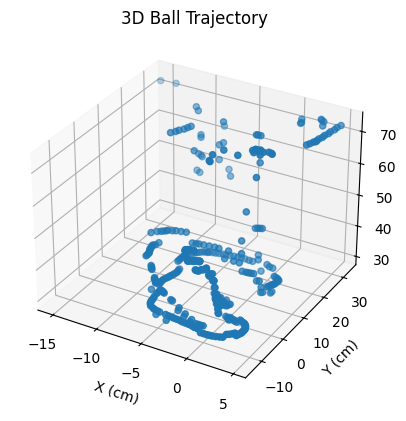

In [41]:
positions = []
for frame in frames:
    edges = preprocess_image(frame)
    circs = detect_circles(edges)
    for x, y, r in circs:
        positions.append(calculate_ball_position(x, y, r))
positions = np.array(positions)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.set_title('3D Ball Trajectory')
plt.show()